#**Multimodal RAG**

Unlike traditional RAG systems that focus solely on text, MultiModal RAG harnesses the power of both textual and visual information.
A lot of real-world data is multimodal in nature, which means a mixture of text, images, tables, and more.
A Multimodal RAG System  can handle mixed data formats using intelligent data transformations and multimodal LLMs.  

## **Multimodal RAG Implementation**
Implementation of Multimodal RAG System using OpenAI SDK and build a simple Chat to my PDF application here.

We will use a multimodal LLM (GPT-4o) to produce text summaries from images


*   Load PDF → extract plain text from every page.
*   Extract every image → feed to GPT-4 for ≤60-word image description .
*   Split text pages into chunks; keep image image description as-is.
*   Embed all chunks with OpenAI text-embedding-3-small → store in Chroma vector DB.
*   On user query, retrieve top-4 relevant chunks → feed them and question to GPT-4 → return concise answer.

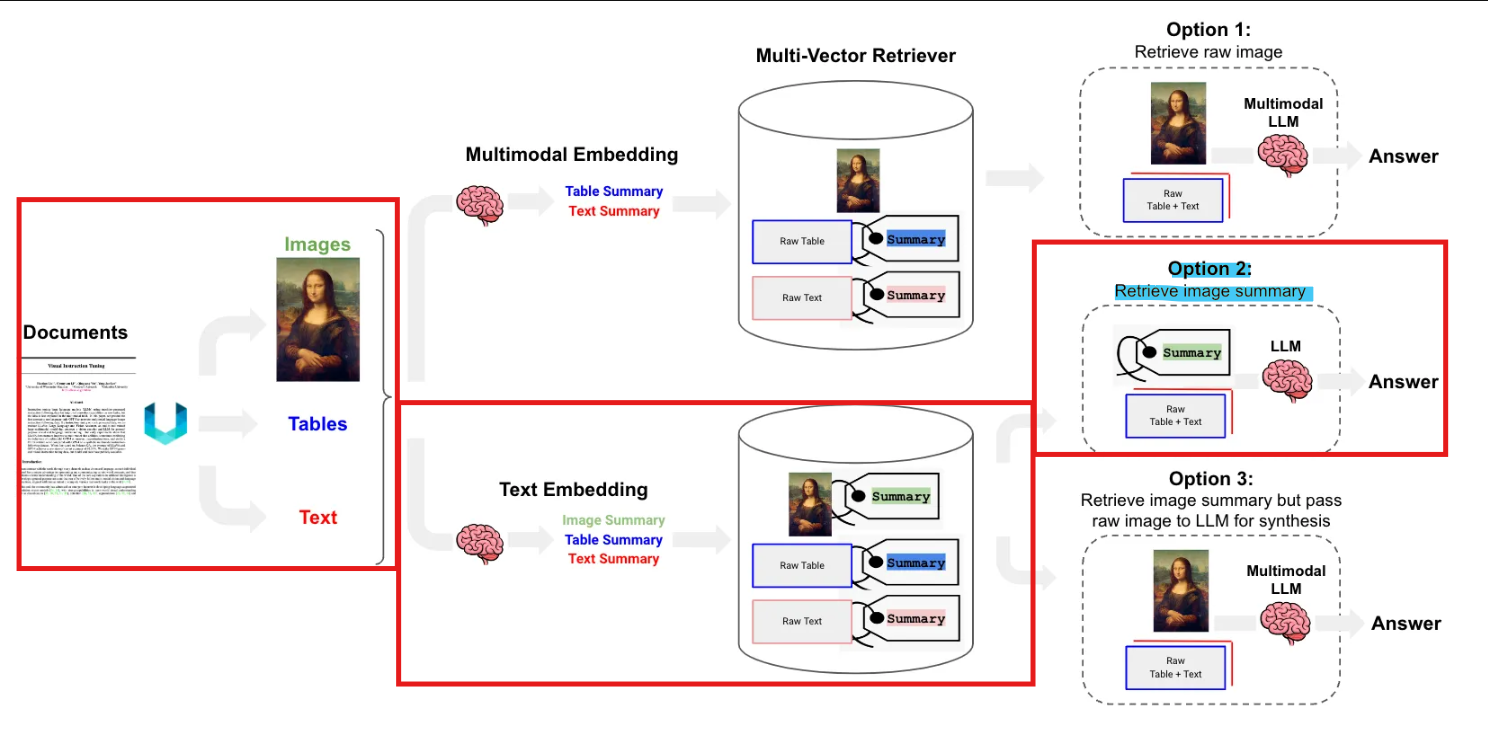










### Install Dependencies

In [ ]:
### Multimodal RAG using OpenAI SDK
!pip install -qU pypdf Pillow openai chromadb tiktoken


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.0/329.0 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.0/220.0 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/10

Data used : Wildfire Statistics

### Downloading Data

In [ ]:
!wget https://www.nifc.gov/sites/default/files/NICC/2-Predictive%20Services/Intelligence/Annual%20Reports/2023/annual_report_2023_0.pdf

--2026-01-16 08:36:59--  https://www.nifc.gov/sites/default/files/NICC/2-Predictive%20Services/Intelligence/Annual%20Reports/2023/annual_report_2023_0.pdf
Resolving www.nifc.gov (www.nifc.gov)... 172.65.90.27, 172.65.90.25, 172.65.90.26, ...
Connecting to www.nifc.gov (www.nifc.gov)|172.65.90.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5337383 (5.1M) [application/pdf]
Saving to: ‘annual_report_2023_0.pdf’

annual_report_2023_ 100%[===================>]   5.09M  25.0MB/s    in 0.2s    

2026-01-16 08:36:59 (25.0 MB/s) - ‘annual_report_2023_0.pdf’ saved [5337383/5337383]



### Load API Key

In [ ]:
from google.colab import userdata

os.environ["OPENAI_API_KEY"]= userdata.get('OPENAI_API_KEY')

### Imports

In [ ]:
import os
from pathlib import Path
import io, base64
from typing import List
import tiktoken

from pypdf import PdfReader          # read PDFs
from PIL import Image                # image handling
from google.colab import files

from openai import OpenAI
import chromadb
from chromadb.config import Settings
from IPython.display import display, Image as IPImage

# Initialize OpenAI client
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

# Simple document class
class Document:
    def __init__(self, page_content: str, metadata: dict = None):
        self.page_content = page_content
        self.metadata = metadata or {}


### Model Initialization

In [ ]:
# We will use the same model for both image summarisation and QA.
# Model is set in the client calls below


### Summarize Image

In [ ]:
# Helper function to describe an image using gpt-4o
def summarize_image(b64_img: str, max_words: int = 60) -> str:
    prompt = (
        f"Describe this image in {max_words} words or fewer. "
        "Focus on charts, tables, or numbers if present."
    )
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/png;base64,{b64_img}"},
                    },
                ],
            }
        ],
        temperature=0
    )
    return response.choices[0].message.content.strip()


### Parse PDF

In [ ]:
pdf_path = Path("/content/annual_report_2023_0.pdf")
reader = PdfReader(pdf_path)

all_docs: List[Document] = []

img_dir = Path("./tmp_images")
img_dir.mkdir(exist_ok=True)

print("Parsing PDF …")
for page_num, page in enumerate(reader.pages):
    # ---------------------Extract plain text--------------
    plain_text = page.extract_text() or ""
    if plain_text.strip():
        all_docs.append(
            Document(
                page_content=plain_text,
                metadata={
                    "source": str(pdf_path),
                    "page": page_num,
                    "kind": "text",
                },
            )
        )

    # ------------------Extract and summarise images-----------------------
    for img_idx, img_file in enumerate(page.images):
        img = Image.open(io.BytesIO(img_file.data))
        buffered = io.BytesIO()
        img.save(buffered, format="PNG")
        b64 = base64.b64encode(buffered.getvalue()).decode()
        summary = summarize_image(b64) #-----------------------call summarize_image

        # save image to tmp_images/
        img_path = img_dir / f"page{page_num}_img{img_idx}.png"
        img.save(img_path)

        all_docs.append(
            Document(
                page_content=f"Image on page {page_num}: {summary}",
                metadata={
                    "source": str(pdf_path),
                    "page": page_num,
                    "kind": "image_summary",
                    "image_path": str(img_path),
                },
            )
        )

print(f"Parsed {len(all_docs)} raw documents (text pages + image summaries).")



Parsing PDF …
Parsed 124 raw documents (text pages + image summaries).


### Chunking

In [ ]:
# Chunk the text (not the images)
# We split only text pages, image summaries are already short.
def split_text_by_tokens(text: str, chunk_size: int = 750, chunk_overlap: int = 100) -> List[str]:
    """Split text into chunks using token count."""
    encoding = tiktoken.encoding_for_model("gpt-4o-mini")
    tokens = encoding.encode(text)
    chunks = []
    start = 0
    while start < len(tokens):
        end = start + chunk_size
        chunk_tokens = tokens[start:end]
        chunk_text = encoding.decode(chunk_tokens)
        chunks.append(chunk_text)
        start = end - chunk_overlap
    return chunks

chunked_docs: List[Document] = []
for doc in all_docs:
    if doc.metadata["kind"] == "image_summary":
        # keep image summaries as-is
        chunked_docs.append(doc)
    else:
        # split textual pages into smaller chunks
        chunks = split_text_by_tokens(doc.page_content, chunk_size=750, chunk_overlap=100)
        for chunk_text in chunks:
            chunked_docs.append(
                Document(
                    page_content=chunk_text,
                    metadata=doc.metadata.copy()
                )
            )

print(f"Data Split into {len(chunked_docs)} final chunks.")


Data Split into 133 final chunks.


### Embedding

In [ ]:
# Embed and Build a vector store using OpenAI SDK and ChromaDB
def create_embeddings(texts: List[str]) -> List[List[float]]:
    """Create embeddings for texts using OpenAI."""
    embeddings = []
    for text in texts:
        response = client.embeddings.create(
            model="text-embedding-3-small",
            input=text
        )
        embeddings.append(response.data[0].embedding)
    return embeddings

# Create ChromaDB collection
chroma_client = chromadb.Client(Settings(anonymized_telemetry=False))
collection = chroma_client.create_collection(name="pdf_rag", get_or_create=True)

# Add documents to ChromaDB
doc_texts = [doc.page_content for doc in chunked_docs]
doc_embeddings = create_embeddings(doc_texts)
doc_metadatas = [doc.metadata for doc in chunked_docs]

collection.add(
    ids=[f"doc_{i}" for i in range(len(chunked_docs))],
    embeddings=doc_embeddings,
    documents=doc_texts,
    metadatas=doc_metadatas
)

print(f"Added {len(chunked_docs)} documents to vector database")


Added 133 documents to vector database


### Retriever

In [ ]:
# Retriever function using OpenAI SDK
def retrieve_documents(query: str, k: int = 4) -> List[Document]:
    """Retrieve documents using semantic search."""
    # Create query embedding
    query_embedding = client.embeddings.create(
        model="text-embedding-3-small",
        input=query
    ).data[0].embedding

    # Search in ChromaDB
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=k
    )

    # Convert results to Document objects
    docs = []
    for i in range(len(results['documents'][0])):
        docs.append(
            Document(
                page_content=results['documents'][0][i],
                metadata=results['metadatas'][0][i]
            )
        )
    return docs

def answer_question(question: str) -> dict:
    """Answer a question using RAG."""
    # Retrieve relevant documents
    retrieved_docs = retrieve_documents(question, k=4)

    # Build context from retrieved documents
    context = "\n\n".join([doc.page_content for doc in retrieved_docs])

    # Create prompt
    prompt = f"""Use the following context to answer the question. If the answer is not in the context, say so.

Context:
{context}

Question: {question}

Answer:"""

    # Get answer from OpenAI
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )

    answer = response.choices[0].message.content.strip()

    return {
        "result": answer,
        "source_documents": retrieved_docs
    }


### Q/A & Show Source

Runs the QA chain on the question and:

1.   Prints the answer
2.   Lists the source chunks
3.   Displays every referenced image inline


In [ ]:
def ask_and_show(question: str):
    print(f"\n {question}")
    answer = answer_question(question)
    print("\n Answer:")
    print(answer["result"])

    print("\n Sources:")
    for doc in answer["source_documents"]:
        print(f"  • page {doc.metadata['page']} ({doc.metadata['kind']}) - {doc.page_content[:180]}...")

    print("\n Referenced images:")
    for doc in answer["source_documents"]:
        if doc.metadata.get("kind") == "image_summary":
            display(IPImage(filename=doc.metadata["image_path"]))


### Ask Questions


 Give me stats on Wildfires by Agency

 Answer:
The statistics on wildfires by agency for the year 2023 are as follows:

- State/Other (ST/OT): 46,176 wildfires
- Forest Service (FS): 5,252 wildfires
- Bureau of Indian Affairs (BIA): 2,633 wildfires
- Bureau of Land Management (BLM): 1,836 wildfires
- National Park Service (NPS): 484 wildfires
- Fish and Wildlife Service (FWS): 199 wildfires

 Sources:
  • page 15 (text) - 14 
 
Wildfires and Acres Burned by Agency and GACC – 2023 & prior years 
  
Agency 
Fires/Acres 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 5-Yr Avg. 10-Yr Avg. 
BIA Fi...
  • page 13 (text) - 12 
 
 
   
 
Wildfires by Agency 
 
The distribution of wildfires by protection agency in 2023 was similar to prior years.  About one-
quarter of the nation’s fires occurred on fe...
  • page 11 (text) - 10 
 
Large Wildfires by Geographic Area and Agency 
 
In 2023, most incidents that met “large fire” criteria occurred in Southern Area and on lands 
protected at

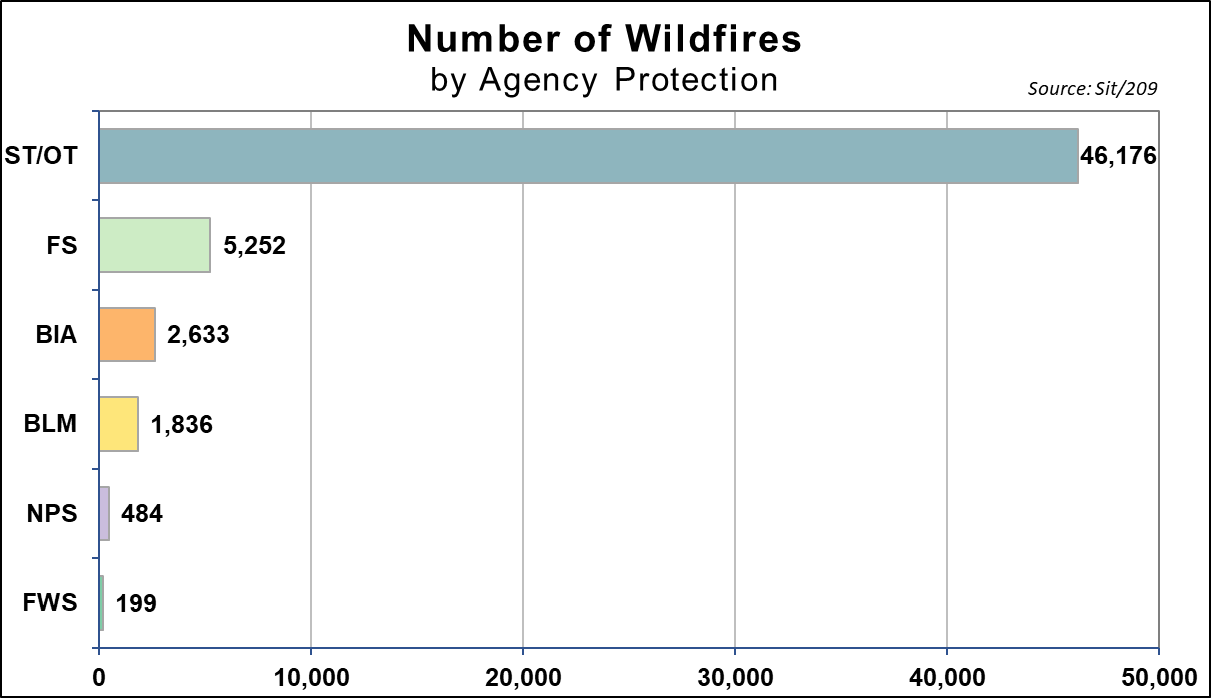

In [ ]:
ask_and_show("Give me stats on Wildfires by Agency")

In [ ]:
ask_and_show("Give me Report on fires caused by human beings.  ")


 Give me Report on fires caused by human beings.  

 Answer:
The report on fires caused by human beings is as follows:

- Total Human-Caused Fires: 50,697
- Total Acres Burned by Human-Caused Fires: 1,533,245

Breakdown by Geographic Area:
- Alaska (AK): 170 fires, 737 acres
- Eastern Area (EA): 10,240 fires, 113,065 acres
- Great Basin (GB): 974 fires, 63,626 acres
- Northern California (NO): 2,779 fires, 17,209 acres
- Northern Rockies (NR): 1,892 fires, 45,705 acres
- Northwest (NW): 2,805 fires, 233,619 acres
- Rocky Mountain (RM): 1,174 fires, 225,324 acres
- Southern Area (SA): 24,627 fires, 594,233 acres
- Southern California (SO): 4,155 fires, 138,115 acres
- Southwest (SW): 1,881 fires, 101,612 acres

 Sources:
  • page 14 (text) - 13 
 
Lightning Fires and Acres by Geographic Area   
 
Fires/ 
Acres  AK EA GB NO NR NW RM SA SO SW Total 
Fires 176 77 777 470 576 882 734 1,081 174 936 5,883 
Acres 313,538 351 ...
  • page 43 (text) - 42 
 
Wildland Fires and Acres Burned by St